In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import scanpy as sc
import os
from collections import defaultdict
import numpy as np
from matplotlib.lines import Line2D

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


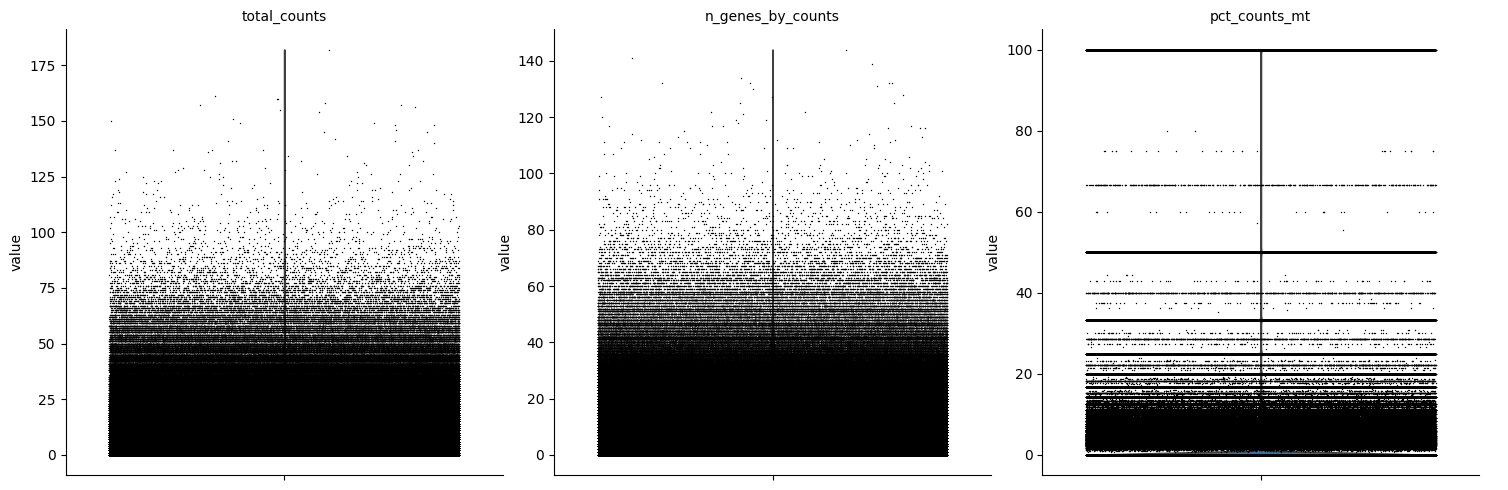

In [3]:
adata = sc.read_10x_h5(
    "../Data/skin_TXK6Z4X_A1/outs/binned_outputs/square_002um/filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

**Divide the large tiff image into 256*256 blocks**

In [ ]:
def split_tif_pil(input_tif, output_folder, tile_size):
    os.makedirs(output_folder, exist_ok=True)

    Image.MAX_IMAGE_PIXELS = None
    img = Image.open(input_tif)
    width, height = img.size

    for i in range(0, width, tile_size):
        for j in range(0, height, tile_size):
            box = (i, j, min(i + tile_size, width), min(j + tile_size, height))
            tile = img.crop(box)

            output_path = os.path.join(output_folder, f"tile_{i}_{j}.tif")
            tile.save(output_path, format="TIFF")
            print(f"Saved {output_path}")


split_tif_pil(
    "../Data/skin_TXK6Z4X_D1_processed/tmap/wsi.tif", "output_tiles", tile_size=256
)

**Change cell maker image background color to transparent**

In [ ]:
A1_cells_layer_path = "../Data/skin_TXK6Z4X_A1_processed/cells_layer.png"
D1_cells_layer_path = "../Data/skin_TXK6Z4X_D1_processed/cells_layer.png"
image = cv2.imread(D1_cells_layer_path)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])


mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Convert the image to RGBA
rgba = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
rgba[:, :, 3] = red_mask

cv2.imwrite("output.png", rgba)

**Human skin cell marker file**

In [28]:
df = pd.read_csv("../Data/cell_marker.txt", sep="\t")
df = df[df["tissueType"] == "Skin"]
df_skin_selected = df[["cancerType", "cellType", "cellName", "cellMarker", "cellMarker", "geneSymbol"]]
df_skin_selected

,cancerType,cellType,cellName,cellMarker,cellMarker,geneSymbol
87,Normal,Normal cell,Endothelial cell,"CD31, VWF","CD31, VWF","PECAM1, VWF"
166,Cutaneous Squamous Cell Carcinoma,Cancer cell,Cancer stem cell,SOX2,SOX2,SOX2
405,Normal,Normal cell,Keratinocyte progenitor cell,ABCG2,ABCG2,ABCG2
627,Normal,Normal cell,Pluripotent stem cell,"CD13, SSEA-4, TRA-1-60","CD13, SSEA-4, TRA-1-60","ANPEP, NA, PODXL"
673,Normal,Normal cell,Keratinocyte,"ALDH, CD44, CD71, Integrin alpha-6","ALDH, CD44, CD71, Integrin alpha-6","ALDH family, CD44, TFRC, ITGA6"
773,Normal,Normal cell,Regulatory T (Treg) cell,CD73,CD73,NT5E
866,Normal,Normal cell,Keratinocyte progenitor cell,"CD34, P63","CD34, P63","CD34, TP63"
979,Melanoma,Cancer cell,Cancer stem cell,CD133,CD133,PROM1
1044,Normal,Normal cell,Langerhans cell,CD1,CD1,CD1 family
1830,Normal,Normal cell,Keratinocyte,CK14,CK14,KRT14


In [29]:
df_skin_selected = df_skin_selected.drop_duplicates()
df_skin_selected

,cancerType,cellType,cellName,cellMarker,cellMarker,geneSymbol
87,Normal,Normal cell,Endothelial cell,"CD31, VWF","CD31, VWF","PECAM1, VWF"
166,Cutaneous Squamous Cell Carcinoma,Cancer cell,Cancer stem cell,SOX2,SOX2,SOX2
405,Normal,Normal cell,Keratinocyte progenitor cell,ABCG2,ABCG2,ABCG2
627,Normal,Normal cell,Pluripotent stem cell,"CD13, SSEA-4, TRA-1-60","CD13, SSEA-4, TRA-1-60","ANPEP, NA, PODXL"
673,Normal,Normal cell,Keratinocyte,"ALDH, CD44, CD71, Integrin alpha-6","ALDH, CD44, CD71, Integrin alpha-6","ALDH family, CD44, TFRC, ITGA6"
773,Normal,Normal cell,Regulatory T (Treg) cell,CD73,CD73,NT5E
866,Normal,Normal cell,Keratinocyte progenitor cell,"CD34, P63","CD34, P63","CD34, TP63"
979,Melanoma,Cancer cell,Cancer stem cell,CD133,CD133,PROM1
1044,Normal,Normal cell,Langerhans cell,CD1,CD1,CD1 family
1830,Normal,Normal cell,Keratinocyte,CK14,CK14,KRT14


In [30]:
df_skin_selected["cellName"]

87                  Endothelial cell
166                 Cancer stem cell
405     Keratinocyte progenitor cell
627            Pluripotent stem cell
673                     Keratinocyte
773         Regulatory T (Treg) cell
866     Keratinocyte progenitor cell
979                 Cancer stem cell
1044                 Langerhans cell
1830                    Keratinocyte
1831                    Keratinocyte
1833                    Keratinocyte
2209                     Merkel cell
2210                     Merkel cell
2211                     Merkel cell
2212        Regulatory T (Treg) cell
2213        Regulatory T (Treg) cell
2214        Regulatory T (Treg) cell
2215                          T cell
2220                Endothelial cell
2223                Endothelial cell
2226                 Langerhans cell
2227                 Langerhans cell
2230                 Progenitor cell
2340             Epidermal stem cell
2341                 Epithelial cell
2418          Myeloid dendritic cell
2

In [ ]:
# Clean the cell names and make them unique
df_skin_selected['cellName_clean'] = df_skin_selected['cellName'].str.replace(r' cell$', '', regex=True)

df_skin_selected['cellName_clean'] = df_skin_selected['cellName_clean'].str.replace(' ', '_')

df_skin_selected['cellName_clean'] = (
    df_skin_selected.groupby('cellName_clean')
    .cumcount()
    .astype(str)
    .radd('_')
    .radd(df_skin_selected['cellName_clean'])
)
df_skin_selected['cellName_clean']
df_skin_selected

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_5561/4185993916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skin_selected['cellName_clean'] = df_skin_selected['cellName'].str.replace(r' cell$', '', regex=True)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_5561/4185993916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skin_selected['cellName_clean'] = df_skin_selected['cellName_clean'].str.replace(' ', '_')
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_

,cancerType,cellType,cellName,cellMarker,cellMarker,geneSymbol,cellName_clean
87,Normal,Normal cell,Endothelial cell,"CD31, VWF","CD31, VWF","PECAM1, VWF",Endothelial_0
166,Cutaneous Squamous Cell Carcinoma,Cancer cell,Cancer stem cell,SOX2,SOX2,SOX2,Cancer_stem_0
405,Normal,Normal cell,Keratinocyte progenitor cell,ABCG2,ABCG2,ABCG2,Keratinocyte_progenitor_0
627,Normal,Normal cell,Pluripotent stem cell,"CD13, SSEA-4, TRA-1-60","CD13, SSEA-4, TRA-1-60","ANPEP, NA, PODXL",Pluripotent_stem_0
673,Normal,Normal cell,Keratinocyte,"ALDH, CD44, CD71, Integrin alpha-6","ALDH, CD44, CD71, Integrin alpha-6","ALDH family, CD44, TFRC, ITGA6",Keratinocyte_0
773,Normal,Normal cell,Regulatory T (Treg) cell,CD73,CD73,NT5E,Regulatory_T_(Treg)_0
866,Normal,Normal cell,Keratinocyte progenitor cell,"CD34, P63","CD34, P63","CD34, TP63",Keratinocyte_progenitor_1
979,Melanoma,Cancer cell,Cancer stem cell,CD133,CD133,PROM1,Cancer_stem_1
1044,Normal,Normal cell,Langerhans cell,CD1,CD1,CD1 family,Langerhans_0
1830,Normal,Normal cell,Keratinocyte,CK14,CK14,KRT14,Keratinocyte_1


In [ ]:
# get each cell‘s geneSymbol
grouped = df_skin_selected.groupby('cellName_clean')['geneSymbol'].apply(list)

for cell, genes in grouped.items():
    quoted_genes = [f'"{gene}"' for gene in genes]
    print(f'{cell}: [{", ".join(quoted_genes)}]')

Cancer_stem_0: ["SOX2"]
Cancer_stem_1: ["PROM1"]
Endothelial_0: ["PECAM1, VWF"]
Endothelial_1: ["PECAM1"]
Endothelial_2: ["PECAM1, CDH5"]
Epidermal_stem_0: ["CD200, CD34, ITGA6, NES, SMCP, TP63, TNC, YAP1"]
Epidermal_stem_1: ["ITGB1, KRT14, FZD2, FZD3, FZD7"]
Epithelial_0: ["ITGAE, VCAM1, IL6R, ANPEP, IL6ST, THBD, CD1D, CD24, CDH1, NOS2"]
Keratinocyte_0: ["ALDH family, CD44, TFRC, ITGA6"]
Keratinocyte_1: ["KRT14"]
Keratinocyte_2: ["ITGB1, KRT19, KRT5, KRT8"]
Keratinocyte_3: ["SPRR2A"]
Keratinocyte_progenitor_0: ["ABCG2"]
Keratinocyte_progenitor_1: ["CD34, TP63"]
Langerhans_0: ["CD1 family"]
Langerhans_1: ["CD1A, CD207"]
Langerhans_2: ["CD1A"]
Merkel_0: ["KRT20"]
Merkel_1: ["KRT18, KRT20"]
Merkel_2: ["NCAM1"]
Myeloid_dendritic_0: ["ITGAM, ITGAX, CCR7, CD1A, CD1B, CD1C, LY75, CD207, CD209, PDCD1LG2, NRP1, CD4, CD40, ITGA4, CD80, CD83, CD86, ADGRE1, HLA-DR family, MHC Class II"]
Pluripotent_stem_0: ["ANPEP, NA, PODXL"]
Progenitor_0: ["EPCAM, PHOX2A, PROM1"]
Regulatory_T_(Treg)_0: ["NT5E"]